In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


##  Data masked

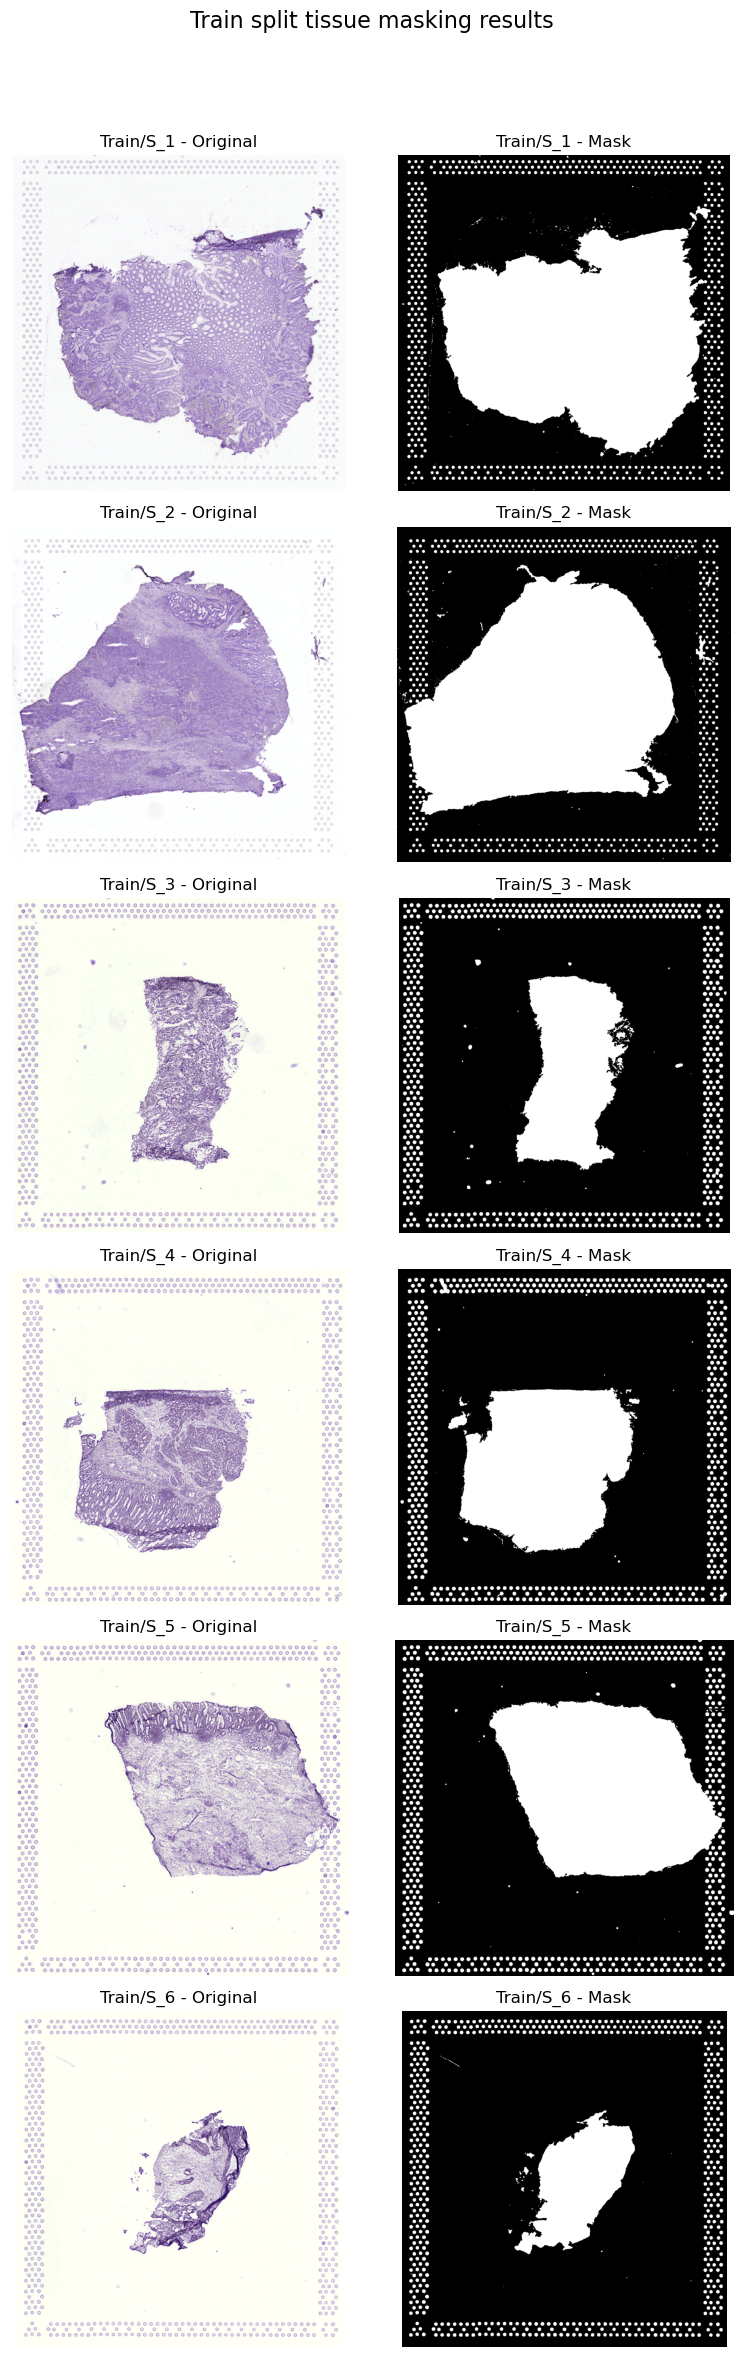

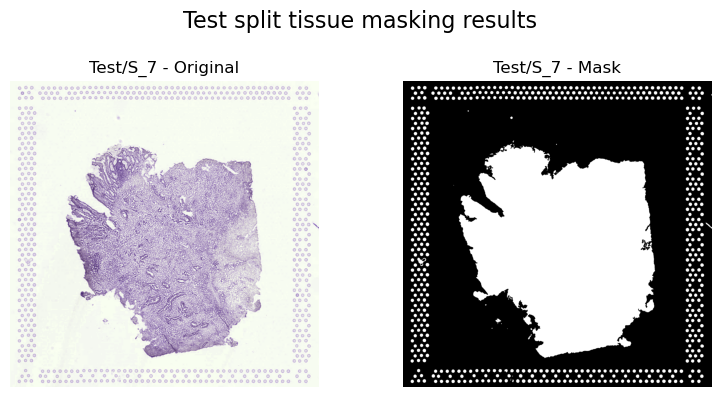

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.morphology import closing, remove_small_holes, disk

# Your custom thresholds
custom_thresholds = {
    "S_1": 0.90,
    "S_2": 0.91,
    "S_3": 0.90,
    "S_4": 0.90,
    "S_5": 0.91,
    "S_6": 0.86,
    "S_7": 0.85,
}

with h5py.File("dataset/Macenko_normalize_imag_S1.h5", "r") as h5file:
    # Loop over both Train and Test splits
    for split in ["Train", "Test"]:
        images_grp = h5file[f"images/{split}"]
        slide_ids = sorted(images_grp.keys())

        n = len(slide_ids)
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(8, 4 * n))
        if n == 1:
            axs = [axs]

        for i, slide_id in enumerate(slide_ids):
            image = np.array(images_grp[slide_id])
            gray  = rgb2gray(image)

            # 1) Binarize
            thresh = custom_thresholds.get(slide_id, threshold_mean(gray))
            mask   = gray <= thresh  # True = tissue

            # 2) Closing to fill small holes
            mask_closed = closing(mask, disk(2))

            # 3) Fill small holes (area < 5000 px)
            mask_filled = remove_small_holes(
                mask_closed,
                area_threshold=5000,
                connectivity=2
            )

            # Original
            axs[i][0].imshow(image)
            axs[i][0].set_title(f"{split}/{slide_id} - Original")
            axs[i][0].axis("off")

            # Mask
            axs[i][1].imshow(mask_filled, cmap="gray")
            axs[i][1].set_title(f"{split}/{slide_id} - Mask")
            axs[i][1].axis("off")

        plt.suptitle(f"{split} split tissue masking results", fontsize=16)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()


In [ ]:
## save after masked

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77847/3182383402.py:76: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77847/3182383402.py:76: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77847/3182383402.py:76: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77847/3182383402.py:76: UserWarning: Glyph 32455 (\N{CJK UNIFIED IDEOGRAPH-7EC7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77847/3182383402.py:76: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0

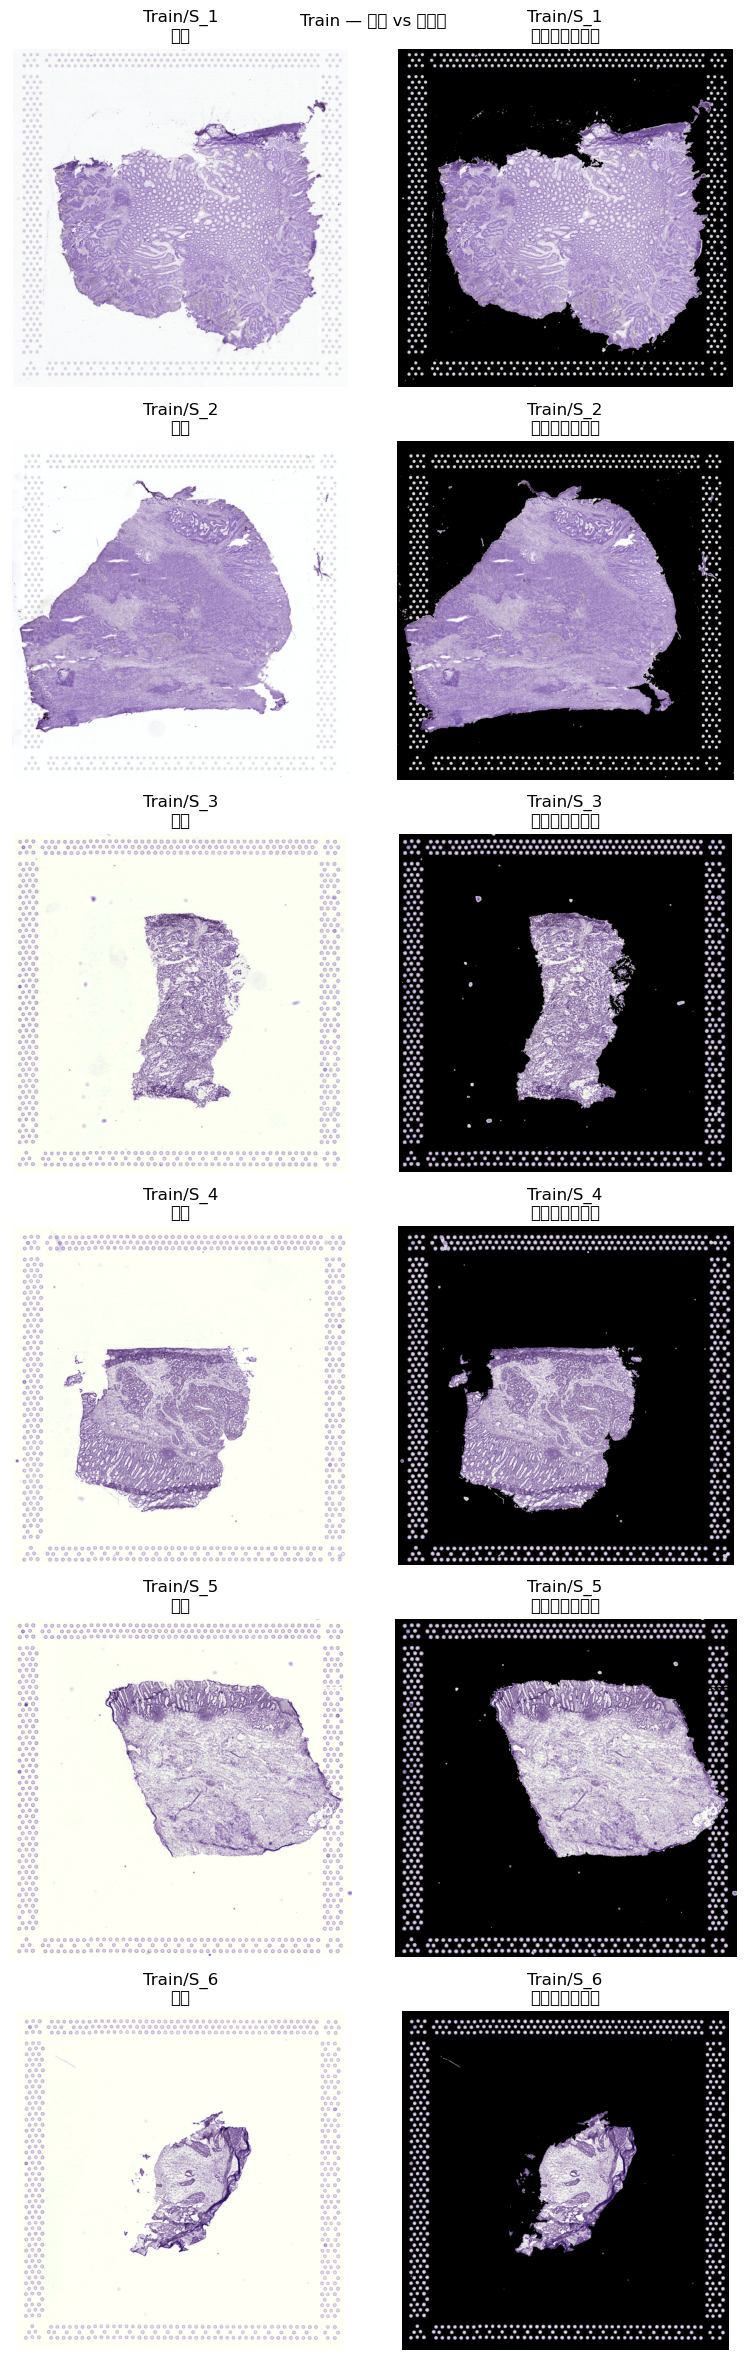

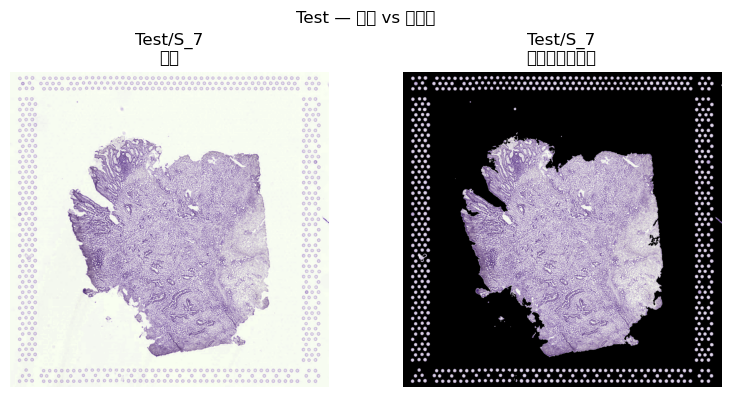

✅ finish masking, save to dataset/try1_masked.h5


In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.morphology import closing, remove_small_holes, disk
import os

# 自定义灰度阈值

custom_thresholds = {
    "S_1": 0.90,
    "S_2": 0.91,
    "S_3": 0.90,
    "S_4": 0.90,
    "S_5": 0.91,
    "S_6": 0.86,
    "S_7": 0.85,
}


# 输入／输出文件
in_path  = "dataset/Macenko_normalize_imag_S1.h5"
out_path = "dataset/try1_masked.h5"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with h5py.File(in_path,  "r") as h5in, \
     h5py.File(out_path, "w") as h5out:

    for split in ["Train", "Test"]:
        grp_in  = h5in[f"images/{split}"]
        grp_out = h5out.create_group(f"images/{split}")

        slide_ids = list(grp_in.keys())
        n = len(slide_ids)
        fig, axs = plt.subplots(n, 2, figsize=(8, 4*n))
        if n==1: axs = np.expand_dims(axs,0)

        for i, sid in enumerate(slide_ids):
            img = np.array(grp_in[sid])  # float32 [0,1]
            gray = rgb2gray(img)

            # 1) 二值化
            thresh = custom_thresholds.get(sid, threshold_mean(gray))
            mask = gray <= thresh       # True=组织

            # 2) 闭运算填洞
            mask_closed = closing(mask, disk(2))
            # 3) 填充剩余小孔
            mask_filled = remove_small_holes(
                mask_closed,
                area_threshold=5000,
                connectivity=2
            )

            # 4) 用 mask_filled 把背景置零 (或 1，看需求)
            masked = img.copy()
            masked[~mask_filled] = 0.0

            # 5) 存储到新 h5
            grp_out.create_dataset(
                sid,
                data=masked
            )

            # 6) 绘图对比
            ax1, ax2 = axs[i]
            ax1.imshow(img)
            ax1.set_title(f"{split}/{sid}\n原图")
            ax1.axis("off")
            ax2.imshow(masked)
            ax2.set_title(f"{split}/{sid}\n组织单元掩码后")
            ax2.axis("off")

        plt.suptitle(f"{split} — 原图 vs 掩码后")
        plt.tight_layout()
        plt.show()

print("✅ finish masking, save to", out_path)
